# Features: Predicting Hospital Admission Using ER Triage Data

## Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

**Data Before Feature Selection**

In [3]:
with open('data/df_clean_few_nulls.pickle', 'rb') as read_file:
    df_clean = pickle.load(read_file)

**Data After Feature Selection**

In [ ]:
with open('data/df_clean_fe.pickle', 'rb') as read_file:
    df_clean = pickle.load(read_file)

## Feature Engineering

In [132]:
# Functions
def normTest(feature):
    print('Shapiro: {}'.format(shapiro(df_clean[feature])))
    print('Anderson: {}'.format(anderson(df_clean[feature])))
    print('Shapiro Log: {}'.format(shapiro(np.log(df_clean[feature]))))
    print('Shapiro Box: {}'.format(shapiro(power_transform(np.array(df_clean[feature]).reshape(-1,1), method= 'box-cox'))))
    sns.distplot(df_clean[feature])
    sns.distplot(power_transform(np.array(df_clean[feature]).reshape(-1,1), method= 'box-cox'))

**Feature Transformation**

Continuous features to check for normality:

1. Age: not normal, bin data, discrete
2. Patient_num_hr: 
3. SBP/DBP
4. HR
5. RR
6. BT
7. Stay_min

Unbalanced Features:
1. Injury
2. Admissions
3. Mental
4. Pain Scale
5. KTAS

In [17]:
from scipy.stats import beta
from scipy.stats import shapiro, anderson
import statsmodels.api as sm
from sklearn.preprocessing import power_transform

**Feature Transformation - Age**

Shapiro Test for normality: Shapiro-Wilks null hypothesis that sample came from normally distributed population

Analysis of Effect Size: QQ Plot

Anderson-Darhling = tests whether a sample comes from a specified cdf (cummulative distribution function)

In [13]:
print(shapiro(df_clean['age']))
print(anderson(df_clean['age']))
# With this p-value I have to reject the null hypothesis that this distribution is normal (p < 0.05)

(0.9609060883522034, 6.057691366319281e-18)
AndersonResult(statistic=14.202624326568184, critical_values=array([0.574, 0.654, 0.785, 0.915, 1.089]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))


In [15]:
log_age = np.log(df_clean['age'])

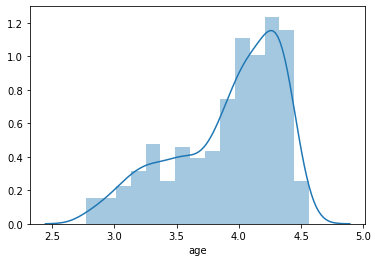

In [16]:
sns.distplot(log_age)

In [20]:
box_age = power_transform(np.array(df_clean['age']).reshape(-1,1), method= 'box-cox')

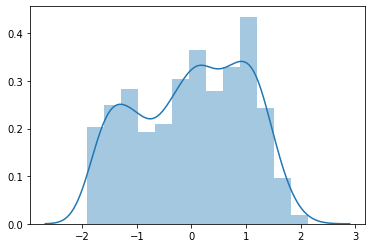

In [21]:
sns.distplot(box_age)

In [24]:
print(shapiro(box_age))
print(anderson(box_age))
# Still not normal... age is discrete so I'm going to bin it

(0.9616021513938904, 8.931332117169832e-18)
AndersonResult(statistic=array([-1264.99400841, -1260.98202524, -1256.97004206, ...,
        3806.15272516,  3810.16470834,  3814.17669151]), critical_values=array([0.574, 0.654, 0.785, 0.915, 1.089]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))


In [32]:
print(sorted(df_clean['age'].unique()))

[16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96]


In [4]:
pd.cut(df_clean['age'], 3)

0         (69.333, 96.0]
1       (42.667, 69.333]
2       (42.667, 69.333]
3         (69.333, 96.0]
4       (42.667, 69.333]
              ...       
1262      (69.333, 96.0]
1263      (69.333, 96.0]
1264      (69.333, 96.0]
1265      (69.333, 96.0]
1266      (69.333, 96.0]
Name: age, Length: 1267, dtype: category
Categories (3, interval[float64]): [(15.92, 42.667] < (42.667, 69.333] < (69.333, 96.0]]

In [176]:
df_clean['age_bins'] = pd.cut(df_clean['age'], 3, labels = ['young', 'middle_age', 'old'])

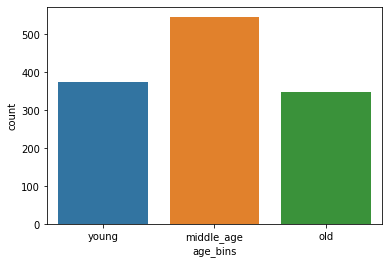

In [177]:
sns.countplot(df_clean['age_bins'])

**Patient Num/ Hr**

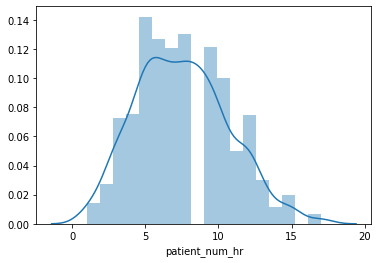

In [41]:
sns.distplot(df_clean['patient_num_hr'])

In [44]:
print(shapiro(df_clean['patient_num_hr']))
print(anderson(df_clean['patient_num_hr']))
# Not normal...this may also be discrete

(0.9794992208480835, 1.9877547958319086e-12)
AndersonResult(statistic=8.229703368223, critical_values=array([0.574, 0.654, 0.785, 0.915, 1.089]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))


Binning

In [174]:
df_clean['patient_freq_bins'] = pd.cut(df_clean['patient_num_hr'], 2, labels = ['low_freq', 'high_freq'])

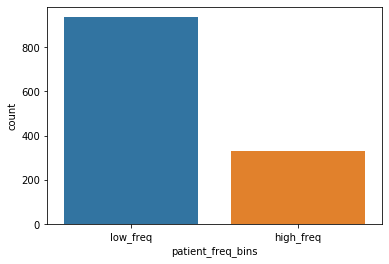

In [175]:
sns.countplot(df_clean['patient_freq_bins'])

**SBP/DBP**

Thought of adding just one feature to simplify (Pulse pressure), but after some reading I think both SBP and DBP could contribute seperately depending on the condition, so I may actually not use PP and just include SBP/DBP

In [51]:
df_clean['PP'] = df_clean['SBP']/df_clean['DBP']

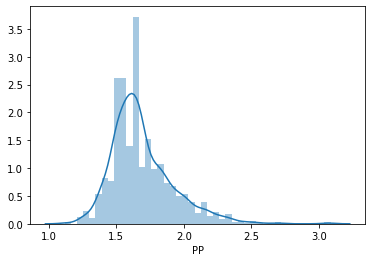

In [52]:
sns.distplot(df_clean['PP'])

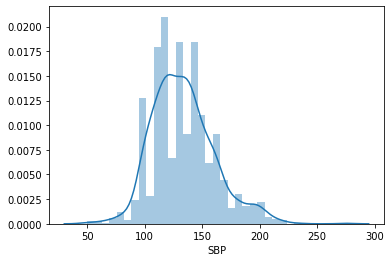

In [56]:
sns.distplot(df_clean['SBP'])

In [58]:
print(shapiro(df_clean['SBP']))
print(anderson(df_clean['SBP']))
# Not normal...transform

(0.9708645939826965, 2.709459557282139e-15)
AndersonResult(statistic=10.203951783680623, critical_values=array([0.574, 0.654, 0.785, 0.915, 1.089]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))


In [61]:
shapiro(np.log(df_clean['SBP']))
#Closer...kind of

(0.9850819706916809, 4.040892065404478e-10)

In [62]:
box_sbp = power_transform(np.array(df_clean['SBP']).reshape(-1,1), method= 'box-cox')

In [64]:
shapiro(box_sbp)
#Still not normal...bin this ish

(0.9869934320449829, 3.3055651549318554e-09)

In [79]:
df_clean['SBP']

0       160.0
1       137.0
2       130.0
3       139.0
4        91.0
        ...  
1262    120.0
1263    120.0
1264    130.0
1265    170.0
1266    150.0
Name: SBP, Length: 1267, dtype: float64

In [178]:
df_clean['SBP_bins'] = pd.cut(df_clean['SBP'], bins = [0,90, 130, 300], labels = ['low_sbp', 'norm_sbp', 'high_sbp'])

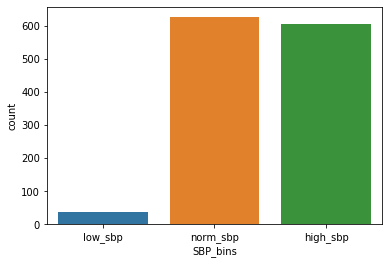

In [179]:
sns.countplot(df_clean['SBP_bins'])

**DBP**

In [180]:
df_clean['DBP_bins'] = pd.cut(df_clean['DBP'], bins = [0,60,80,200], labels = ['low_dbp', 'norm_dpb', 'high_dbp'])

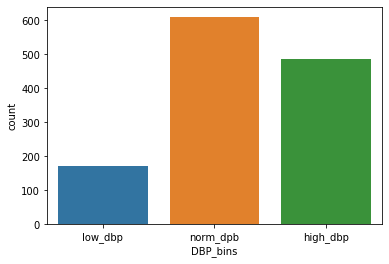

In [181]:
sns.countplot(df_clean['DBP_bins'])

**HR**

Shapiro: (0.9885898232460022, 2.2107331076881565e-08)
Anderson: AndersonResult(statistic=4.469312278121379, critical_values=array([0.574, 0.654, 0.785, 0.915, 1.089]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
Shapiro Log: (0.9892656803131104, 5.174464590140815e-08)
Shapiro Box: (0.9949921369552612, 0.0003196276957169175)


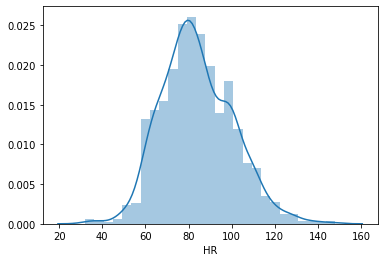

In [100]:
normTest('HR')

In [5]:
pd.cut(df_clean['HR'], 3)

0       (70.667, 109.333]
1        (31.884, 70.667]
2       (70.667, 109.333]
3       (70.667, 109.333]
4       (70.667, 109.333]
              ...        
1262    (70.667, 109.333]
1263    (70.667, 109.333]
1264    (70.667, 109.333]
1265    (70.667, 109.333]
1266     (31.884, 70.667]
Name: HR, Length: 1267, dtype: category
Categories (3, interval[float64]): [(31.884, 70.667] < (70.667, 109.333] < (109.333, 148.0]]

In [182]:
df_clean['HR_bins'] = pd.cut(df_clean['HR'], 3, labels = ['low_hr', 'norm_hr', 'high_hr'])

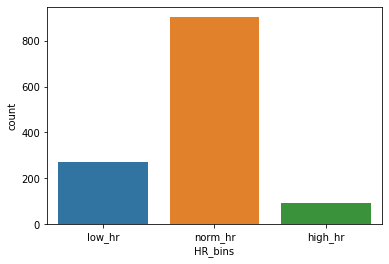

In [183]:
sns.countplot(df_clean['HR_bins'])

**RR**

Shapiro: (0.7540397047996521, 8.521436091405645e-40)
Anderson: AndersonResult(statistic=135.71132200215607, critical_values=array([0.574, 0.654, 0.785, 0.915, 1.089]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
Shapiro Log: (0.7731597423553467, 1.2124597635320976e-38)
Shapiro Box: (0.7746453285217285, 1.5015137252994707e-38)


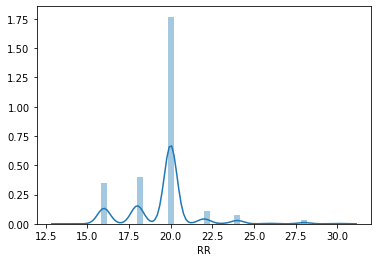

In [109]:
normTest('RR')
#Very Discrete

In [6]:
pd.cut(df_clean['RR'], 2)

0       (13.984, 22.0]
1       (13.984, 22.0]
2       (13.984, 22.0]
3       (13.984, 22.0]
4       (13.984, 22.0]
             ...      
1262    (13.984, 22.0]
1263    (13.984, 22.0]
1264    (13.984, 22.0]
1265    (13.984, 22.0]
1266    (13.984, 22.0]
Name: RR, Length: 1267, dtype: category
Categories (2, interval[float64]): [(13.984, 22.0] < (22.0, 30.0]]

In [184]:
df_clean['RR_bins'] = pd.cut(df_clean['RR'], 2, labels = ['norm_rr', 'high_rr'])

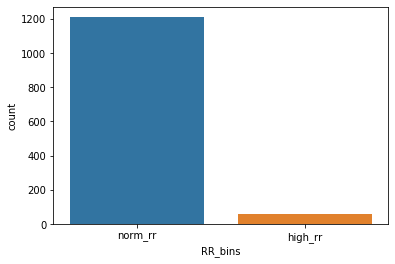

In [185]:
sns.countplot(df_clean['RR_bins'])

**BT**

Shapiro: (0.84376060962677, 1.4743049229658168e-33)
Anderson: AndersonResult(statistic=38.803414670637494, critical_values=array([0.574, 0.654, 0.785, 0.915, 1.089]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
Shapiro Log: (0.8543819189071655, 1.2207557322431427e-32)
Shapiro Box: (1.0, 1.0)


/Users/brittb28/anaconda3/envs/metis/lib/python3.6/site-packages/scipy/stats/morestats.py:1657: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


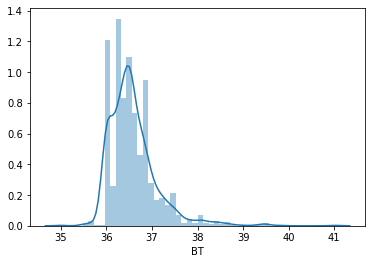

In [116]:
normTest('BT')

In [186]:
df_clean['BT_bins'] = pd.cut(df_clean['BT'], bins = [35,37.5,50], labels = ['norm_bt', 'high_bt'])

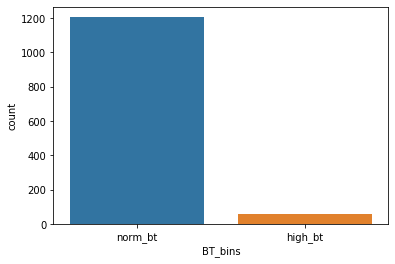

In [187]:
sns.countplot(df_clean['BT_bins'])

**stay_min**

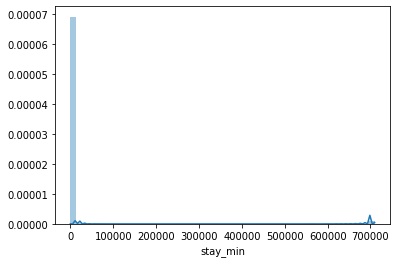

In [125]:
sns.distplot(df_clean['stay_min'])

In [130]:
df_clean.loc[df_clean['stay_min'] == 0, 'stay_min'] = 0.0000001

Shapiro: (0.10665255784988403, 0.0)
Anderson: AndersonResult(statistic=452.755884906456, critical_values=array([0.574, 0.654, 0.785, 0.915, 1.089]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
Shapiro Log: (0.5791832804679871, 0.0)
Shapiro Box: (0.7987540364265442, 5.717879329359887e-37)


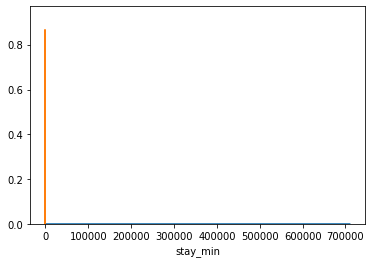

In [133]:
normTest('stay_min')

In [137]:
df_clean['stay_bins'] = pd.cut(df_clean['stay_min'], bins = [0,120, 340, 480, 1440, 100000000000], 
                         labels = ['0-2hr', '2-4hr', '4-8hr', '8-24hr', '24hr+'])

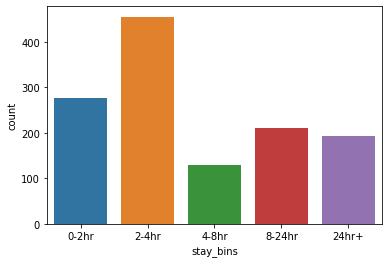

In [138]:
sns.countplot(df_clean['stay_bins'])

**Pain Scale**

In [188]:
df_clean['pain_bins'] = pd.cut(df_clean['pain_scale'],3, labels = ['low_pain', 'med_pain', 'high_pain'])

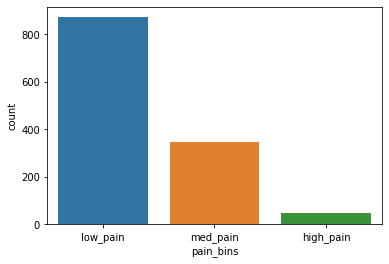

In [189]:
sns.countplot(df_clean['pain_bins'])

In [151]:
df_clean['mental_bins'] = pd.cut(df_clean['mental'], bins = [0,1.1,4], labels = ['alert', 'not_alert'])

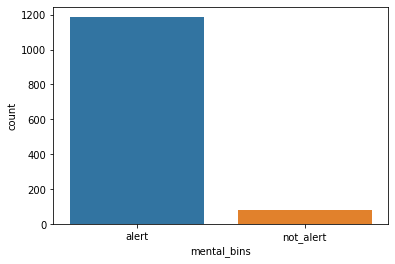

In [152]:
sns.countplot(df_clean['mental_bins'])

**Feature Selection** - Decide which features to use

    1. Both hospitals, sex, age_bins, patient_freq_bins, arrival_mode (dummies), injury, mental_bins, pain_bins, KTAS expert, SBP_bins, DBP_bins, HR_bins, RR_bins, BT_bins, stay_bins
    Note: Injury, mental, and pain_scale could be correlated. Need to run models and get stats to find out. Pain is just a binary yes or no definitely correlated to pain-scale. So running a model with pain and one with pain_scale
    
    2. Same as 1. but swap pain (binary) for pain_bins
    
    3. Same as 1. but swap KTAS_RN for KTAS_expert
    
   Make a decisio about pain vs pain_scale and KTAS_expert vs KTAS_RN
    
    4. Hospital 1 (subset), sex, age_bins, patient_freq_bins, arrival_mode (dummies), injury, mental, pain_bins, KTAS expert, SBP_bins, DBP_bins, HR_bins, RR_bins, BT_bins, stay_bins, saturation
    
    5. Hospital 0 (subset), sex, age_bins, patient_freq_bins, arrival_mode (dummies), injury, mental, pain_bins, KTAS expert, SBP_bins, DBP_bins, HR_bins, RR_bins, BT_bins, stay_bins
    
   Decide if saturation is important or if it's easier to predict within 1 hospital vs another
    
    6. Drop KTAS to see if it's possible to predict without triage

Cut Features

Use variance method and other statistics

**Get Dummy Variables and Build X for model 1**

Get dummies for arrival mode

In [153]:
df_clean.columns

Index(['hospital', 'sex', 'age', 'patient_num_hr', 'arrival_mode', 'injury',
       'complaint', 'mental', 'pain', 'pain_scale', 'SBP', 'DBP', 'HR', 'RR',
       'BT', 'saturation', 'KTAS_RN', 'diagnosis', 'result', 'KTAS_expert',
       'error_code', 'stay_min', 'KTAS_duration_min', 'mistriage',
       'admissions', 'age_bins', 'patient_freq_bins', 'PP', 'SBP_bins',
       'DBP_bins', 'HR_bins', 'RR_bins', 'BT_bins', 'stay_bins', 'pain_bins',
       'mental_bins'],
      dtype='object')

In [190]:
arrival_mode = pd.get_dummies(df_clean['arrival_mode'], drop_first = True)

In [191]:
age_bins =  pd.get_dummies(df_clean['age_bins'], drop_first = True)
patient_freq_bins = pd.get_dummies(df_clean['patient_freq_bins'], drop_first = True)
sbp_bins = pd.get_dummies(df_clean['SBP_bins'], drop_first = True)
dbp_bins = pd.get_dummies(df_clean['DBP_bins'], drop_first = True)
hr_bins = pd.get_dummies(df_clean['HR_bins'], drop_first = True)
rr_bins = pd.get_dummies(df_clean['RR_bins'], drop_first = True)
bt_bins = pd.get_dummies(df_clean['BT_bins'], drop_first = True)
stay_bins = pd.get_dummies(df_clean['stay_bins'], drop_first = True)
pain_bins = pd.get_dummies(df_clean['pain_bins'], drop_first = True)
mental_bins = pd.get_dummies(df_clean['mental_bins'], drop_first=True)
KTAS_expert = pd.get_dummies(df_clean['KTAS_expert'], drop_first = True)

Not dealing with complaint and diagnosis grouping for now

In [193]:
not_dummies = df_clean[['hospital', 'sex', 'injury', 'admissions']]

In [197]:
# Removing stay bins, because this is cheating
df_fe = pd.concat([not_dummies, age_bins, patient_freq_bins, sbp_bins, dbp_bins, hr_bins, rr_bins,
          bt_bins, pain_bins, mental_bins, KTAS_expert], axis = 1)

In [198]:
with open('data/df_clean_fe.pickle', 'wb') as to_write:
    pickle.dump(df_fe, to_write)